# Learning and Evaluating a Probabilistic Circuit

In [a previous notebook](../learning-a-gaussian-mixture-model) we show how to construct and learn a circuit with ```cirkit```, manually building the symbolic circuit by hand. However, this can get quite cumbersome once we have enough input features.

In this notebook, we will see how to **leverage built-in functions** from ```cirkit``` to easily build a deep circuit with (potentially) million of parameters. In particular, we will fit such a model on the MNIST dataset, and see how we can evaluate it on unseen images, marginalize/condition some pixels, and sample new images.

Next, we show how to construct a symbolic circuit whose structure and parameterization is tailored for images.

## Constructing the Symbolic Circuit

The **symbolic circuit** is a symbolic abstraction of a tensorized circuit. This representation tracks the layer connections, number of units per layer, and other useful metadata about the parameters, such as their shape and parameterization choices. 

We provide in ```cirkit.templates``` helper functions to build symbolic circuits with different structures. We will use one tailored for image data, providing some arguments that determine the shape and form of the circuit. 

For example, we choose _QuadGraph_ as our region graph which exploits the closeness of patches of pixels. See the [notebook on region graphs and sum product layers](../region-graphs-and-parametrisation) for more details about region graphs. 

In [60]:
from cirkit.templates import data_modalities, utils

symbolic_circuit = data_modalities.image_data(
    (1, 28, 28),                # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
    region_graph='quad-graph',  # Select the structure of the circuit to follow the QuadGraph region graph
    input_layer='categorical',  # Use Categorical distributions for the pixel values (0-255) as input layers
    num_input_units=64,         # Each input layer consists of 64 Categorical input units
    sum_product_layer='cp',     # Use CP sum-product layers, i.e., alternate dense layers with Hadamard product layers
    num_sum_units=64,           # Each dense sum layer consists of 64 sum units
    sum_weight_param=utils.Parameterization(
        activation='softmax',   # Parameterize the sum weights by using a softmax activation
        initialization='normal' # Initialize the sum weights by sampling from a standard normal distribution
    )
)

We can query some information regarding the symbolic circuit, such as the number of variables it is defined on, and which structural properties it does satisfy.

In [61]:
# Print some information
print(f'Number of variables: {symbolic_circuit.num_variables}')
print()

# Print which structural properties the circuit satisfies
print(f'Structural properties:')
print(f'  - Smoothness: {symbolic_circuit.is_smooth}')
print(f'  - Decomposability: {symbolic_circuit.is_decomposable}')
print(f'  - Structured-decomposability: {symbolic_circuit.is_structured_decomposable}')

Number of variables: 784

Structural properties:
  - Smoothness: True
  - Decomposability: True
  - Structured-decomposability: False


## Compiling the Symbolic Circuit with PyTorch

In [62]:
import random
import numpy as np
import torch

# Set some seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the torch device to use
device = torch.device('cuda')

Note that *a symbolic circuit does not allocate parameters and cannot be used for learning or inference*, we need to **compile** the symbolic circuit. 

By default, ```cirkit``` compiles symbolic circuits using PyTorch 2+. Namely, it yields a regular [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) representing a tensorized circuit. 

Next, we import and use the ```compile``` function from ```cirkit.pipeline```.

In [63]:
%%time
from cirkit.pipeline import compile
circuit = compile(symbolic_circuit)

CPU times: user 1.54 s, sys: 6.33 ms, total: 1.55 s
Wall time: 1.54 s


Note that the compilation took a couple seconds for a circuit with >5700 layers and ~25M parameters!

In [64]:
# Print some statistics
num_layers = len(list(symbolic_circuit.layers))
print(f"Number of layers: {num_layers}")
num_parameters = sum(p.numel() for p in circuit.parameters())
print(f"Number of learnable parameters: {num_parameters}")

Number of layers: 5725
Number of learnable parameters: 25657730


## Learning a Probabilistic Circuit using PyTorch

Learning the probabilistic circuit we have compiled above can be done _in the same way as any other neural network_ written using PyTorch.

Next, we load MNIST with [torchvision](https://pytorch.org/vision/stable/index.html), and select one of the many optimizers available in PyTorch, such as [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [21]:
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Flatten the images and set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Initialize a torch optimizer of your choice,
#  e.g., Adam, by passing the parameters of the circuit
optimizer = optim.Adam(circuit.parameters(), lr=0.01)

Finally, we write a basic training loop to iterate over MNIST images for some epochs, optimizing the circuit parameters by minimizing the average  negative log-likelihood.

In [22]:
num_epochs = 10
step_idx = 0
running_loss = 0.0
running_samples = 0

# Move the circuit to chosen device
circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    for i, (batch, _) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_variables)
        batch = batch.to(device)

        # Compute the log-likelihoods of the batch, by evaluating the circuit
        log_likelihoods = circuit(batch)

        # We take the negated average log-likelihood as loss
        loss = -torch.mean(log_likelihoods)
        loss.backward()
        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * len(batch)
        running_samples += len(batch)
        step_idx += 1
        if step_idx % 200 == 0:
            average_nll = running_loss / running_samples
            print(f"Step {step_idx}: Average NLL: {average_nll:.3f}")
            running_loss = 0.0
            running_samples = 0

Step 200: Average NLL: 2501.196
Step 400: Average NLL: 946.254
Step 600: Average NLL: 821.438
Step 800: Average NLL: 783.204
Step 1000: Average NLL: 763.972
Step 1200: Average NLL: 752.012
Step 1400: Average NLL: 743.246
Step 1600: Average NLL: 736.359
Step 1800: Average NLL: 732.234
Step 2000: Average NLL: 727.142
Step 2200: Average NLL: 723.434


Then, we can evaluate our probabilistic circuit on test data by computing the average log-likelihood and bits per dimension.

In [65]:
with torch.no_grad():
    test_lls = 0.0

    for batch, _ in test_dataloader:
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        batch = batch.to(device)

        # Compute the log-likelihoods of the batch
        log_likelihoods = circuit(batch)

        # Accumulate the log-likelihoods
        test_lls += log_likelihoods.sum().item()

    # Compute average test log-likelihood and bits per dimension
    average_ll = test_lls / len(data_test)
    bpd = -average_ll / (28 * 28 * np.log(2.0))
    print(f"Average test LL: {average_ll:.3f}")
    print(f"Bits per dimension: {bpd:.3f}")

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

And, finally, we can use the circuit to sample more images as follows:

In [54]:
from cirkit.backend.torch.queries import SamplingQuery

num_samples = 1
query = SamplingQuery(circuit)

samples, _ = query(num_samples=num_samples)
samples.shape

torch.Size([1, 784])

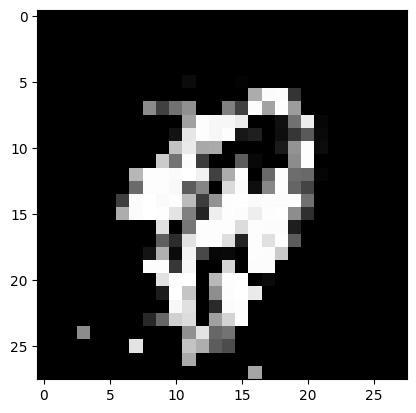

In [55]:
import matplotlib.pyplot as plt
plt.imshow(samples[0].view((28, 28)).numpy(), cmap='gray', vmin=0, vmax=255)